In [3]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Load the dataset using numpy
data = np.genfromtxt("/Users/davidstroud/cloud_logs/anomaly_detection/engineered_logs_100k.csv", delimiter=',', dtype=None, encoding='utf-8', skip_header=1)

# Select feature indices based on CSV structure
# Assuming the columns are in the order they were mentioned before
hour_idx = 8
action_count_idx = 13
failed_actions_count_idx = 12
resource_type_idx = 3
event_type_idx = 4
action_idx = 5
region_idx = 6
target_idx = 10

# Extract features and target
X = np.array([
    [row[hour_idx], row[action_count_idx], row[failed_actions_count_idx], row[resource_type_idx], row[event_type_idx], row[action_idx], row[region_idx]]
    for row in data
])
y = np.array([row[target_idx] for row in data]).astype(int)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipeline
numeric_features = [0, 1, 2]  # Indices for hour, action_count, failed_actions_count
categorical_features = [3, 4, 5, 6]  # Indices for resource_type, event_type, action, region

# Create a column transformer with pipelines for numeric and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)  # Make sure to output dense
    ])

# Fit and transform training data, transform test data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Convert the processed data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)

# Display the shape of the tensor to confirm the conversion
X_train_tensor.shape, X_test_tensor.shape


(torch.Size([80000, 35]), torch.Size([20000, 35]))

In [4]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Create DataLoader for training
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, X_train_tensor)  # Input and target are the same for autoencoder
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the autoencoder class
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize the autoencoder
input_dim = X_train_tensor.shape[1]
encoding_dim = 14
autoencoder = Autoencoder(input_dim, encoding_dim)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Training the autoencoder
num_epochs = 50
autoencoder.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for data in train_loader:
        inputs, _ = data
        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/50], Loss: 0.0855
Epoch [2/50], Loss: 0.0483
Epoch [3/50], Loss: 0.0459
Epoch [4/50], Loss: 0.0457
Epoch [5/50], Loss: 0.0456
Epoch [6/50], Loss: 0.0456
Epoch [7/50], Loss: 0.0456
Epoch [8/50], Loss: 0.0456
Epoch [9/50], Loss: 0.0456
Epoch [10/50], Loss: 0.0456
Epoch [11/50], Loss: 0.0456
Epoch [12/50], Loss: 0.0456
Epoch [13/50], Loss: 0.0456
Epoch [14/50], Loss: 0.0456
Epoch [15/50], Loss: 0.0456
Epoch [16/50], Loss: 0.0456
Epoch [17/50], Loss: 0.0456
Epoch [18/50], Loss: 0.0456
Epoch [19/50], Loss: 0.0456
Epoch [20/50], Loss: 0.0456
Epoch [21/50], Loss: 0.0456
Epoch [22/50], Loss: 0.0456
Epoch [23/50], Loss: 0.0456
Epoch [24/50], Loss: 0.0456
Epoch [25/50], Loss: 0.0456
Epoch [26/50], Loss: 0.0456
Epoch [27/50], Loss: 0.0456
Epoch [28/50], Loss: 0.0456
Epoch [29/50], Loss: 0.0456
Epoch [30/50], Loss: 0.0456
Epoch [31/50], Loss: 0.0456
Epoch [32/50], Loss: 0.0456
Epoch [33/50], Loss: 0.0456
Epoch [34/50], Loss: 0.0456
Epoch [35/50], Loss: 0.0456
Epoch [36/50], Loss: 0.0456
E

In [5]:
# Use the autoencoder to make predictions on the test set
autoencoder.eval()
with torch.no_grad():
    reconstructions = autoencoder(X_test_tensor)
    mse = nn.MSELoss(reduction='none')(reconstructions, X_test_tensor).mean(dim=1)

# Set a threshold for anomaly detection
threshold = torch.quantile(mse, 0.95)  # 95th percentile

# Predict anomalies
y_pred_autoencoder = (mse > threshold).numpy().astype(int)

# Evaluate the autoencoder model
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
print("Autoencoder Classification Report:")
print(classification_report(y_test, y_pred_autoencoder))
print("Autoencoder Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_autoencoder))
print("Autoencoder ROC AUC Score:", roc_auc_score(y_test, y_pred_autoencoder))


Autoencoder Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.95      0.84     14947
           1       0.25      0.05      0.08      5053

    accuracy                           0.72     20000
   macro avg       0.50      0.50      0.46     20000
weighted avg       0.62      0.72      0.65     20000

Autoencoder Confusion Matrix:
[[14205   742]
 [ 4801   252]]
Autoencoder ROC AUC Score: 0.5001146474519356


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# Use the autoencoder to make predictions on the test set
autoencoder.eval()
with torch.no_grad():
    reconstructions = autoencoder(X_test_tensor)
    mse = nn.MSELoss(reduction='none')(reconstructions, X_test_tensor).mean(dim=1)

# Set a threshold for anomaly detection based on the 95th percentile
threshold = torch.quantile(mse, 0.95)

# Predict anomalies
y_pred_autoencoder = (mse > threshold).numpy().astype(int)

# Evaluate the autoencoder model
print("Autoencoder Classification Report:")
print(classification_report(y_test, y_pred_autoencoder))
print("Autoencoder Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred_autoencoder)
print(conf_matrix)


Autoencoder Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.95      0.84     14947
           1       0.25      0.05      0.08      5053

    accuracy                           0.72     20000
   macro avg       0.50      0.50      0.46     20000
weighted avg       0.62      0.72      0.65     20000

Autoencoder Confusion Matrix:
[[14205   742]
 [ 4801   252]]


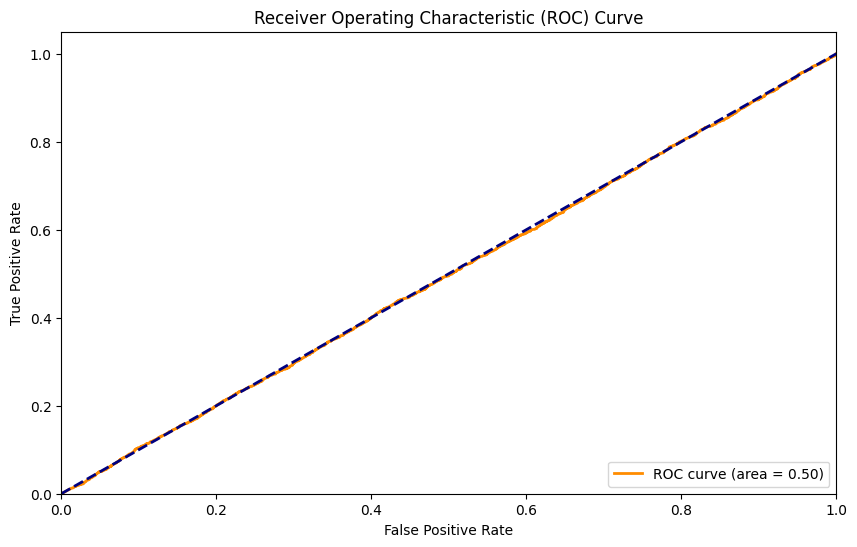

In [7]:
# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, mse)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


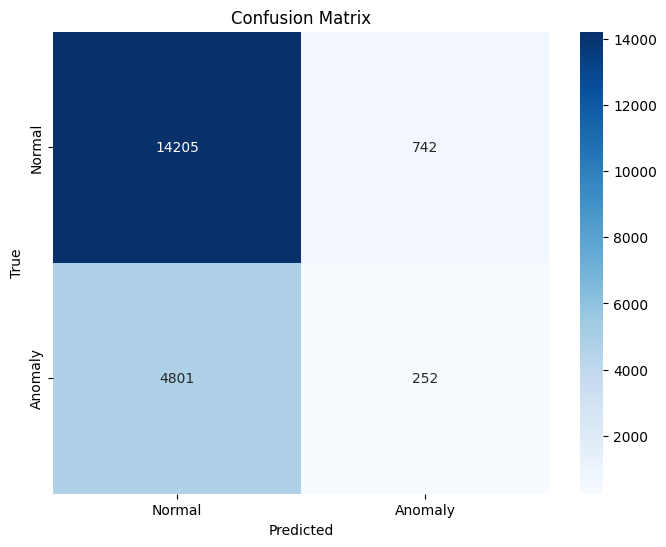

In [8]:
import seaborn as sns

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


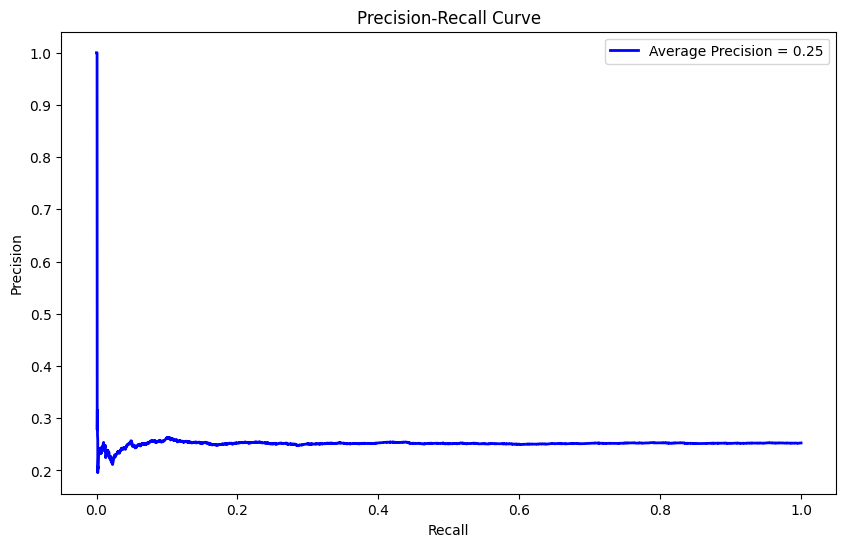

In [9]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, mse)
average_precision = average_precision_score(y_test, mse)

# Plot precision-recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Average Precision = {average_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()
